In [1]:
import configparser
import os
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta

In [2]:
config = configparser.ConfigParser()
config.read("capstone.cfg")

['capstone.cfg']

In [3]:
os.chdir(config["PATH"]["project"])
project_path = config["PATH"]["project"]

Create spark session. Add driver postgress to enable to load from existing postgres DB


In [4]:
# add driver postgress to enable to load from existing postgres DB
spark = SparkSession \
    .builder \
    .appName("covid_weather") \
    .config("spark.jars", "postgresql-42.2.18.jar")\
    .config( "spark.driver.extraClassPath", "postgresql-42.2.18.jar")\
    .getOrCreate()

In [7]:
data_root = os.path.join(project_path, 'DATA/')

In [171]:
nyt = pd.read_csv( os.path.join(data_root, "us-counties.txt") )
nyt = nyt.astype( {"fips" : 'Int64', "deaths": 'Int64'})
nyt.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


In [172]:
nyt.shape

(988671, 6)

## Daily cases

From cumulated cases an deaths, get the daily cases

In [173]:
nyt.sort_values([ "state", "fips","county", "date"] , inplace = True)
nyt.index = range(len(nyt))
nyt

,date,county,state,fips,cases,deaths
0,2020-03-24,Autauga,Alabama,1001,1,0
1,2020-03-25,Autauga,Alabama,1001,4,0
2,2020-03-26,Autauga,Alabama,1001,6,0
3,2020-03-27,Autauga,Alabama,1001,6,0
4,2020-03-28,Autauga,Alabama,1001,6,0
...,...,...,...,...,...,...
988666,2021-02-01,Weston,Wyoming,56045,609,4
988667,2020-04-08,Unknown,Wyoming,<NA>,30,0
988668,2020-04-09,Unknown,Wyoming,<NA>,5,0
988669,2020-04-13,Unknown,Wyoming,<NA>,1,0


In [174]:
group_nyt = nyt.groupby(["county", "state", "fips"])

In [177]:
nyt["daily_cases"] = group_nyt["cases"].diff().fillna( nyt["cases"])
nyt["daily_deaths"] = group_nyt["deaths"].diff().fillna( nyt["deaths"])

In [180]:
nyt[nyt["county"] == "New York City"]

,date,county,state,fips,cases,deaths,daily_cases,daily_deaths
580980,2020-03-01,New York City,New York,<NA>,1,0,1.0,0
580981,2020-03-02,New York City,New York,<NA>,1,0,1.0,0
580982,2020-03-03,New York City,New York,<NA>,2,0,2.0,0
580983,2020-03-04,New York City,New York,<NA>,2,0,2.0,0
580984,2020-03-05,New York City,New York,<NA>,4,0,4.0,0
...,...,...,...,...,...,...,...,...
581313,2021-01-28,New York City,New York,<NA>,591160,26856,591160.0,26856
581314,2021-01-29,New York City,New York,<NA>,597312,26953,597312.0,26953
581315,2021-01-30,New York City,New York,<NA>,603428,27042,603428.0,27042
581316,2021-01-31,New York City,New York,<NA>,608862,27138,608862.0,27138


In [178]:
nyt[ nyt["daily_deaths"]< 0]["daily_deaths"].value_counts().sort_index()

-512       1
-132       1
-76        1
-55        1
-54        2
-50        1
-46        1
-36        1
-28        2
-27        1
-26        1
-24        1
-23        1
-21        3
-18        1
-17        1
-16        4
-15        2
-13        3
-12        5
-11        5
-10        7
-9        10
-8        11
-7        13
-6        12
-5        31
-4        51
-3        86
-2       293
-1      3220
Name: daily_deaths, dtype: Int64

In [116]:
nyt[ nyt["daily_deaths"] == -512]

,date,county,state,fips,cases,deaths,daily_cases,daily_deaths
571472,2020-08-06,Nassau,New York,36059,43534,2194,52.0,-512


<AxesSubplot:>

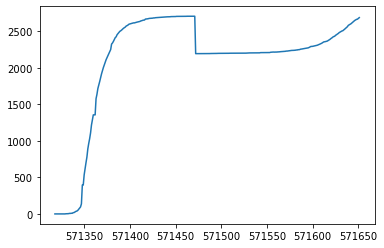

In [119]:
nyt[ nyt["fips"] == 36059 ]["deaths"].plot()

In [139]:
fips_anomalies = nyt[ nyt["daily_deaths"] < -50]["fips"]
fips_anomalies

519365    31055
562811    36001
571472    36059
580172    36119
704966    42091
938364    53053
Name: fips, dtype: Int64

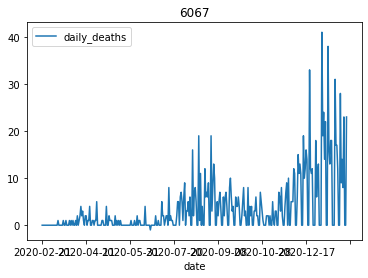

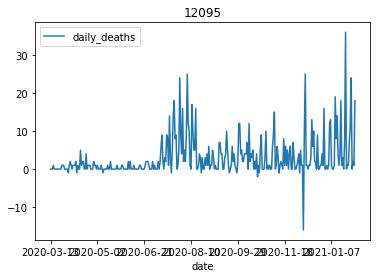

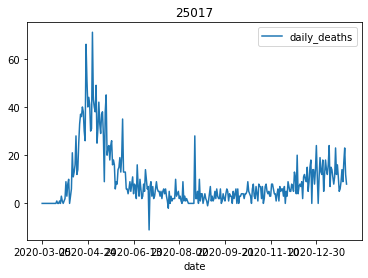

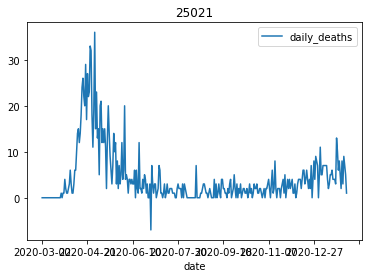

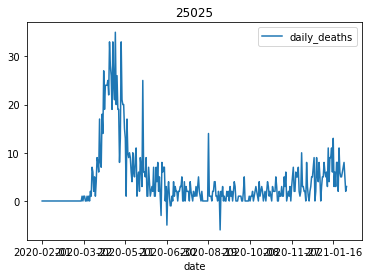

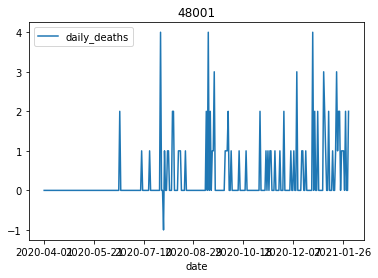

In [155]:
for fips in fips_anomalies:
    nyt[ nyt["fips"] == fips][["date","daily_deaths"]].plot( x = "date", y = "daily_deaths", title = fips)
    

In [151]:
nyt[ nyt["daily_cases"]< 0]["daily_cases"].value_counts().sort_index().head(20)

-2321.0    1
-1750.0    1
-1481.0    1
-1157.0    1
-1068.0    1
-1044.0    1
-787.0     1
-771.0     1
-734.0     1
-709.0     1
-626.0     1
-613.0     1
-529.0     1
-528.0     1
-511.0     1
-458.0     1
-451.0     1
-443.0     1
-419.0     1
-392.0     1
Name: daily_cases, dtype: int64

In [152]:
fips_anomalies = nyt[ nyt["daily_cases"] < -1000]["fips"]
fips_anomalies

67984      6067
115228    12095
380993    25017
381648    25021
382339    25025
798974    48001
Name: fips, dtype: Int64

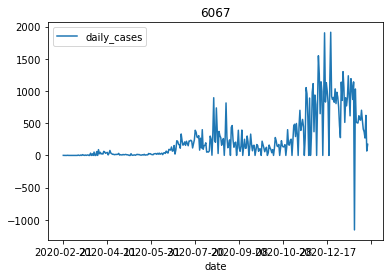

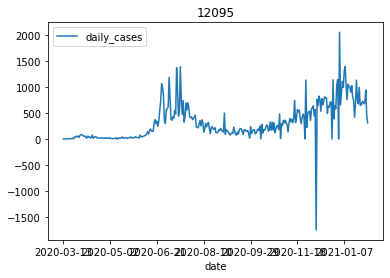

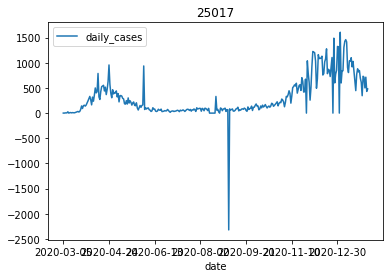

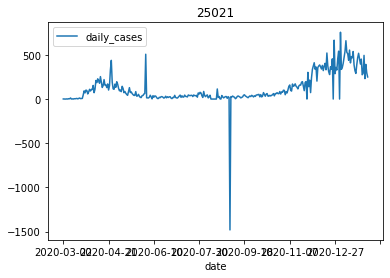

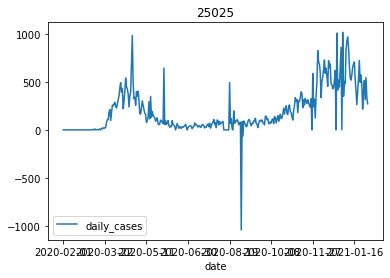

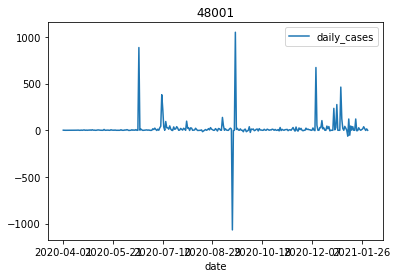

In [154]:
for fips in fips_anomalies:
    nyt[ nyt["fips"] == fips][["date","daily_cases"]].plot( x = "date", y = "daily_cases", title = fips)

In [159]:
nyt["date"].max()

'2021-02-01'

<AxesSubplot:xlabel='date'>

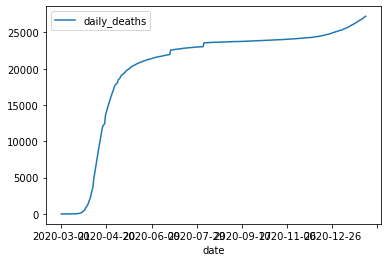

In [168]:
nyt[nyt["county"] == "New York City"][["date", "daily_deaths"]].plot(x="date", y="daily_deaths")

In [170]:
nyt[nyt["county"] == "New York City"]

,date,county,state,fips,cases,deaths,daily_cases,daily_deaths
580980,2020-03-01,New York City,New York,<NA>,1,0,1.0,0
580981,2020-03-02,New York City,New York,<NA>,1,0,1.0,0
580982,2020-03-03,New York City,New York,<NA>,2,0,2.0,0
580983,2020-03-04,New York City,New York,<NA>,2,0,2.0,0
580984,2020-03-05,New York City,New York,<NA>,4,0,4.0,0
...,...,...,...,...,...,...,...,...
581313,2021-01-28,New York City,New York,<NA>,591160,26856,591160.0,26856
581314,2021-01-29,New York City,New York,<NA>,597312,26953,597312.0,26953
581315,2021-01-30,New York City,New York,<NA>,603428,27042,603428.0,27042
581316,2021-01-31,New York City,New York,<NA>,608862,27138,608862.0,27138
